<a href="https://colab.research.google.com/github/azamafridi23/chatbot-in-python-using-deep-learning/blob/main/CHATBOT_in_python_using_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

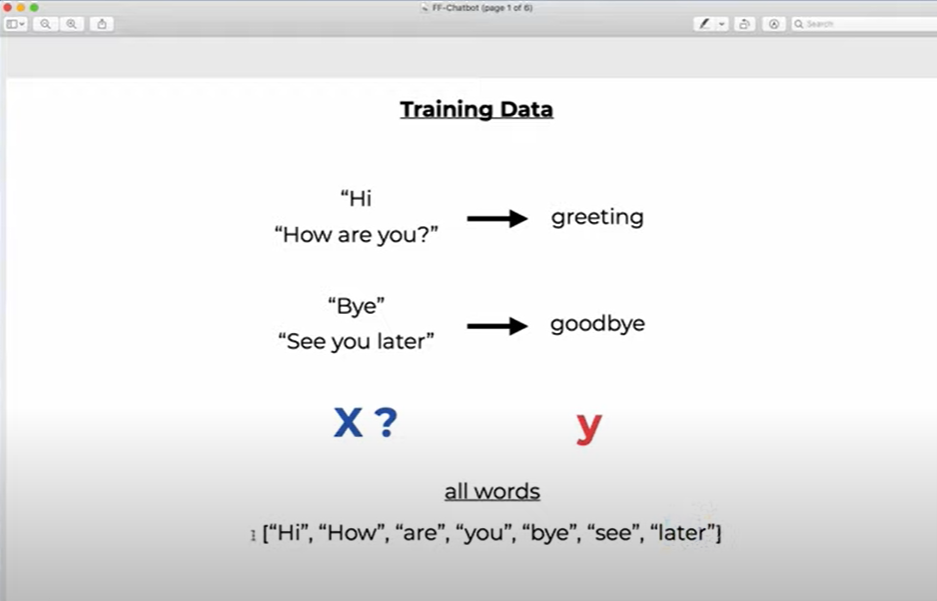


The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

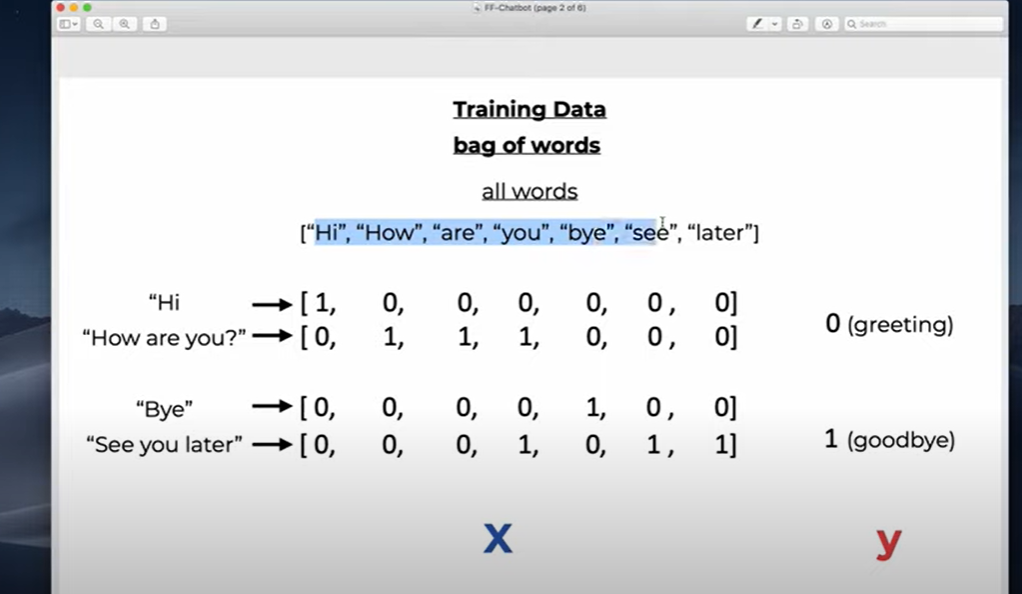

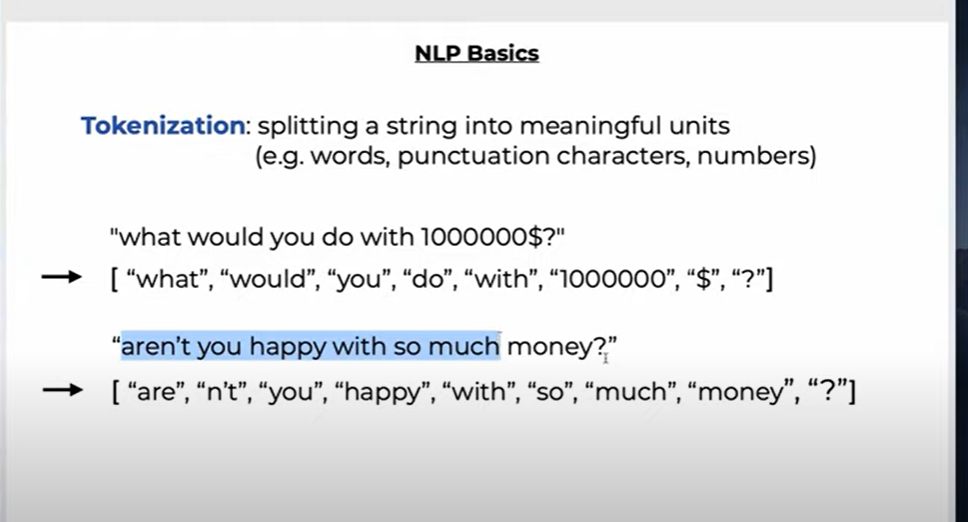

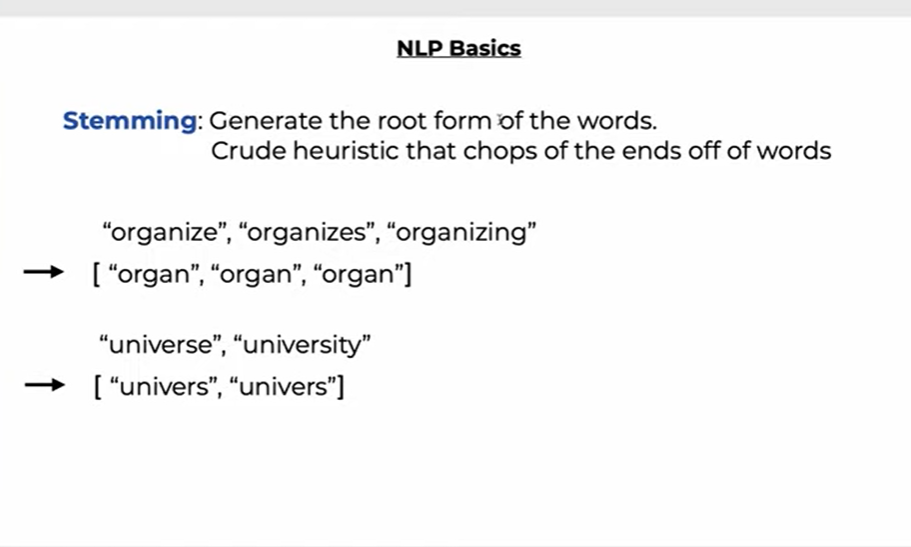

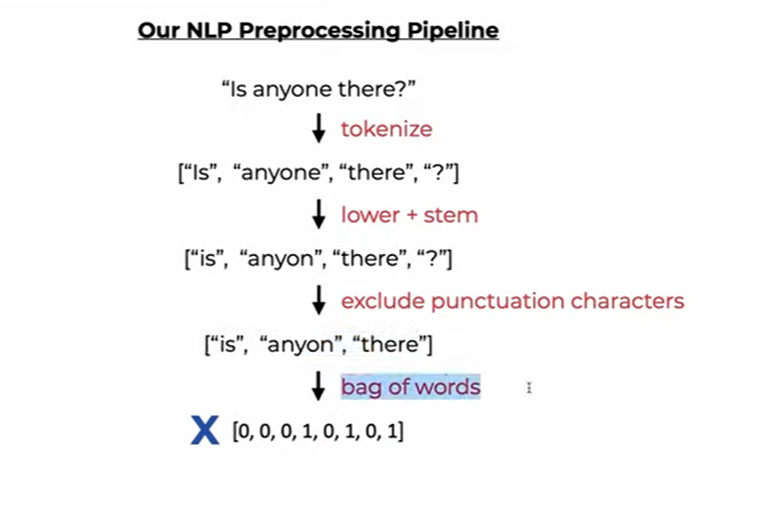

In [ ]:
import nltk
import numpy as np
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer # there are multiple stemmer available

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def tokenize(sentence):
  return nltk.word_tokenize(sentence)


In [ ]:
# testing
tokenize('hello how r u?')

['hello', 'how', 'r', 'u', '?']

In [ ]:
def stem(word):
  stemmer = PorterStemmer()
  return stemmer.stem(word.lower())

In [ ]:
stem('cooking')

'cook'

In [ ]:
# testing
words = ['organize','organizes','organizing']
stemmed_words = [stem(w) for w in words]
print(stemmed_words)

['organ', 'organ', 'organ']


In [ ]:
def bag_of_words(tokenized_sentence,all_words):
  tokenized_sentence = [stem(w) for w in tokenized_sentence]
  bag=np.zeros(len(all_words),dtype=np.float32)
  for idx,w in enumerate(all_words):
    if w in tokenized_sentence:
      bag[idx]=1.0
  return bag


In [ ]:
#testing

sentence=['hello','how','are']
words= ['hi','hello','I','are']
bag=bag_of_words(sentence,words)
print(bag)

[0. 1. 0. 1.]


Training data

In [ ]:
import json

In [ ]:
with open('intents.json','r') as f:
  intents=json.load(f)

print(intents)

{'intents': [{'tag': 'greeting', 'patterns': ['Hi', 'Hey', 'How are you', 'Is anyone there?', 'Hello', 'Good day'], 'responses': ['Hey :-)', 'Hello, thanks for visiting', 'Hi there, what can I do for you?', 'Hi there, how can I help?']}, {'tag': 'goodbye', 'patterns': ['Bye', 'See you later', 'Goodbye'], 'responses': ['See you later, thanks for visiting', 'Have a nice day', 'Bye! Come back again soon.']}, {'tag': 'thanks', 'patterns': ['Thanks', 'Thank you', "That's helpful", "Thank's a lot!"], 'responses': ['Happy to help!', 'Any time!', 'My pleasure']}, {'tag': 'items', 'patterns': ['Which items do you have?', 'What kinds of items are there?', 'What do you sell?'], 'responses': ['We sell coffee and tea', 'We have coffee and tea']}, {'tag': 'payments', 'patterns': ['Do you take credit cards?', 'Do you accept Mastercard?', 'Can I pay with Paypal?', 'Are you cash only?'], 'responses': ['We accept VISA, Mastercard and Paypal', 'We accept most major credit cards, and Paypal']}, {'tag': 'd

In [ ]:
all_words=[]
tags=[]
xy=[]
for intent in intents['intents']:
  tag=intent['tag']
  tags.append(tag)
  for pattern in intent['patterns']:
    w=tokenize(pattern)
    all_words.extend(w)
    xy.append((w,tag)) # appending tuples of (w,tag)

ignore_words = ['?','!','.',',']
#print(all_words)
all_words=[stem(w) for w in all_words if w not in ignore_words]
#print(all_words)
all_words=sorted(set(all_words)) # converted to set to remove duplicate words
print('all_words = ',all_words)
tags=sorted(set(tags))
print('tags = ',tags)


all_words =  ["'s", 'a', 'accept', 'anyon', 'are', 'bye', 'can', 'card', 'cash', 'credit', 'day', 'deliveri', 'do', 'doe', 'funni', 'get', 'good', 'goodby', 'have', 'hello', 'help', 'hey', 'hi', 'how', 'i', 'is', 'item', 'joke', 'kind', 'know', 'later', 'long', 'lot', 'mastercard', 'me', 'my', 'of', 'onli', 'pay', 'paypal', 'see', 'sell', 'ship', 'someth', 'take', 'tell', 'thank', 'that', 'there', 'what', 'when', 'which', 'with', 'you']
tags =  ['delivery', 'funny', 'goodbye', 'greeting', 'items', 'payments', 'thanks']


In [ ]:
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
X_train=[]
y_train=[]

for (pattern_sentence,tag) in xy:
  bag=bag_of_words(pattern_sentence,all_words)
  X_train.append(bag)
  label=tags.index(tag)
  y_train.append(label) #sometimes better to have 1hotencoded. Here we just want class labels so we will use crossentropyloss

X_train=np.array(X_train)
y_train=np.array(y_train)



In [ ]:
class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [ ]:
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=0)

In [ ]:
import torch
import torch.nn as nn


In [ ]:
class neuralnet(nn.Module):
  def __init__(self,input_size,hidden_size,num_classes):
    super(neuralnet,self).__init__()
    self.l1=nn.Linear(input_size,hidden_size)
    self.l2=nn.Linear(hidden_size,hidden_size)
    self.l3=nn.Linear(hidden_size,num_classes)
    self.relu=nn.ReLU()

  def forward(self,x):
    out=self.l1(x)
    out=self.relu(out)
    out=self.l2(out)
    out=self.relu(out)
    out=self.l3(out)
    # no softmax bcz we use cross_entropy
    return out





In [ ]:
learning_rate=0.01
num_epochs=100
input_size=len(X_train[0])
output_size=len(tags)
hidden_size = 8

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(device)

cuda


In [ ]:
model=neuralnet(input_size,hidden_size,output_size).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
  for (words,labels) in train_loader:
    words=words.to(device)
    labels=labels.to(device)
    # forward
    outputs=model(words)
    loss=criterion(outputs,labels)
    #backward with optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if(epoch+1)%10==0:
    print(f'epoch {(epoch+1)}/{(num_epochs)} , loss={loss.item():4f}')

print(f'final_loss = {loss.item():4f}')


epoch 10/100 , loss=2.080749
epoch 20/100 , loss=0.583011
epoch 30/100 , loss=0.122937
epoch 40/100 , loss=0.010232
epoch 50/100 , loss=0.004872
epoch 60/100 , loss=0.003025
epoch 70/100 , loss=0.000988
epoch 80/100 , loss=0.001030
epoch 90/100 , loss=0.000735
epoch 100/100 , loss=0.000506
final_loss = 0.000506


SAVING AND LOADING MODEL

In [ ]:
data={
    'model_state':model.state_dict(),
    'input_size':input_size,
    'output_size':output_size,
    'hidden_size':hidden_size,
    'all_words':all_words,
    'tags':tags
}

In [ ]:
# name of file to be stored as
FILE='data.pth' #pth = pytorch
torch.save(data,FILE)

In [ ]:
# for remaining code. go to collab and see these
import random
import json
import torch


In [ ]:
with open('intents.json','r') as f:
  intents=json.load(f)

FILE='data.pth'
data=torch.load(FILE)
input_size=data['input_size']
output_size=data['output_size']
hidden_size=data['hidden_size']
all_words=data['all_words']
tags=data['tags']
model_state=data['model_state']

In [ ]:
model=neuralnet(input_size,hidden_size,output_size).to(device)
model.load_state_dict(model_state)
model.eval()

neuralnet(
  (l1): Linear(in_features=54, out_features=8, bias=True)
  (l2): Linear(in_features=8, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=7, bias=True)
  (relu): ReLU()
)

CHATBOT

In [ ]:
bot_name='MAXXY'
print('lets chat! Type "quit" to exit')
while True:
  sentence=input('You: ')
  if sentence == 'quit':
    break
  sentence=tokenize(sentence)
  X=bag_of_words(sentence,all_words)
  X=X.reshape(1,X.shape[0])
  X=torch.from_numpy(X).to(device)

  output=model(X)
  _,predicted=torch.max(output,dim=1)
  tag=tags[predicted.item()]
  
  probs = torch.softmax(output, dim=1)
  prob = probs[0][predicted.item()]
  for intent in intents['intents']:
    if tag == intent["tag"]:
      print(f'{bot_name} : ',random.choice(intent['responses']))


lets chat! Type "quit" to exit
You: hi
MAXXY :  Hello, thanks for visiting
You: i love you
MAXXY :  Have a nice day
You: i am sad
MAXXY :  Hi there, what can I do for you?
You: sleep
MAXXY :  See you later, thanks for visiting
You: quit
